<a href="https://colab.research.google.com/github/sayana25/CreditCardRisk_ML-QML/blob/main/gCANS_modular_TFIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.5 MB/s eta 0:00:00


In [24]:
import numpy as np
from scipy.stats import multinomial
import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers


#Sets up hyperparameters and tracking variables

def initialize_gcans_state(obs, coeffs, min_shots, N, params, mu=0.99, b=1e-6, lr=0.05):
    lipschitz = np.sum(np.abs(coeffs))
    if lr > 2 / lipschitz:
        raise ValueError("Learning rate must be less than", 2 / lipschitz)

    state = {
        "obs": obs,
        "coeffs": coeffs,
        "lipschitz": lipschitz,
        "min_shots": min_shots,
        "mu": mu,
        "b": b,
        "lr": lr,
        "shots_used": 0,
        "k": 0,
        "s": np.zeros_like(params, dtype=np.float64) + min_shots,
        "chi": None,
        "xi": None,
        "max_shots": N
    }
    return state

#Simulates single-shot samples of the Hamiltonian for stochastic gradient estimation.

def estimate_hamiltonian(params, shots, state, device=None):
    coeffs = state["coeffs"]
    obs = state["obs"]

    num_wires = len(obs[0].wires)  # assumes all observables span same wires

    if device is None:
        device = qml.device("default.qubit", wires=num_wires, shots=100, seed=93754352)

    prob_shots = np.abs(coeffs) / np.sum(np.abs(coeffs))
    si = multinomial(n=shots, p=prob_shots)
    shots_per_term = si.rvs()[0]

    results = []

    @qml.qnode(device, diff_method="parameter-shift", interface="autograd")
    def qnode(weights, observable):
        StronglyEntanglingLayers(weights, wires=device.wires)
        return qml.sample(observable)

    for o, c, p, s in zip(obs, coeffs, prob_shots, shots_per_term):
        if s == 0:
            continue
        res = qnode(params, o, shots=int(s))
        if s == 1:
            res = np.array([res])
        results.append(c * res / p)

    return np.concatenate(results)
#Uses parameter shift to get noisy gradient + variance.
def evaluate_grad_var(i, params, shots, state):
    shift = np.zeros_like(params)
    shift[i] = np.pi / 2
    forward = estimate_hamiltonian(params + shift, shots, state)
    backward = estimate_hamiltonian(params - shift, shots, state)

    g = np.mean(forward - backward) / 2
    s = np.var((forward - backward) / 2, ddof=1)
    return g, s
#Updates parameters using gradient descent and redistributes shots optimally.
def gcans_step(params, state):
    grad = []
    S = []
    p_ind = list(np.ndindex(*params.shape))

    for i in p_ind:
        g_, s_ = evaluate_grad_var(i, params, int(state["s"][i]), state)
        grad.append(g_)
        S.append(s_)

    grad = np.reshape(np.stack(grad), params.shape)
    S = np.reshape(np.stack(S), params.shape)

    state["shots_used"] += int(2 * np.sum(state["s"]))
    print(f"Shots used: {state['shots_used']}")

    if state["xi"] is None:
        state["xi"] = np.zeros_like(params, dtype=np.float64)
    if state["chi"] is None:
        state["chi"] = np.zeros_like(params, dtype=np.float64)

    mu = state["mu"]
    state["xi"] = mu * state["xi"] + (1 - mu) * S
    xi = state["xi"] / (1 - mu ** (state["k"] + 1))

    state["chi"] = mu * state["chi"] + (1 - mu) * grad
    chi = state["chi"] / (1 - mu ** (state["k"] + 1))

    params = params - state["lr"] * grad

    lipschitz = state["lipschitz"]
    lr = state["lr"]
    s_new = np.zeros_like(params, dtype=np.float64)
    for l in p_ind:
        s_new[l] = np.ceil(
            (2 * lipschitz * lr * xi[l] * np.sum(xi)) /
            ((2 - lipschitz * lr) * (np.linalg.norm(chi) ** 2))
        )

    state["s"] = np.clip(s_new, min(2, state["min_shots"]), state["max_shots"] / len(params))
    state["k"] += 1
    return params, state

In [25]:
# Set random seed
np.random.seed(4)

# TFIM parameters
J = 1.0
g = 1.5
num_wires = 2  # number of qubits
num_layers = 2

# Define Hamiltonian terms for TFIM
coeffs = []
obs = []

# ZZ interaction terms (nearest-neighbor)
for i in range(num_wires - 1):  # open boundary
    coeffs.append(-J)
    obs.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))

# X transverse field terms
for i in range(num_wires):
    coeffs.append(-g)
    obs.append(qml.PauliX(i))

# Create Hamiltonian
H_tfim = qml.Hamiltonian(coeffs, obs)

# Devices
analytic_dev = qml.device("default.qubit", wires=num_wires, shots=None)
non_analytic_dev = qml.device("default.qubit", wires=num_wires, shots=100, seed=432423)

# Parameters
param_shape = StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_wires)
init_params = np.random.uniform(low=0.0, high=2 * np.pi, size=param_shape)
params = init_params

# Probabilistic shot allocation for sampling (can still use if needed)
total_shots = 8000
prob_shots = np.abs(coeffs) / np.sum(np.abs(coeffs))
print("Shot probabilities:", prob_shots)
si = multinomial(n=total_shots, p=prob_shots)

# Cost function with analytic device
@qml.qnode(analytic_dev, interface="autograd")
def cost_analytic(weights):
    StronglyEntanglingLayers(weights, wires=range(num_wires))
    return qml.expval(H_tfim)

Shot probabilities: [0.25  0.375 0.375]


In [26]:
N = 1_000_000
params = init_params

# Initialize optimizer state
state = initialize_gcans_state(obs, coeffs, min_shots=100, N=N, params=params)

cost_gcans = [cost_analytic(params)]
shots_gcans = [0]
iteration = 1

while state["shots_used"] < state["max_shots"]:
    print(f"Running iteration: {iteration}")

    # Perform optimizer step
    params, state = gcans_step(params, state)

    # Evaluate cost and store metrics
    cost_gcans.append(cost_analytic(params))
    shots_gcans.append(state["shots_used"])

    print(f"Step {iteration}: cost = {cost_gcans[-1]}, shots_used = {shots_gcans[-1]}")
    iteration += 1


Running iteration: 1
Shots used: 2400
Step 1: cost = -0.6444697254320857, shots_used = 2400
Running iteration: 2
Shots used: 2584
Step 2: cost = -0.9283417714424708, shots_used = 2584
Running iteration: 3
Shots used: 2776
Step 3: cost = -1.1807233608571401, shots_used = 2776
Running iteration: 4
Shots used: 2984
Step 4: cost = -1.269258515131281, shots_used = 2984
Running iteration: 5
Shots used: 3272
Step 5: cost = -1.4839336958766842, shots_used = 3272
Running iteration: 6
Shots used: 3536
Step 6: cost = -1.6249535801110808, shots_used = 3536
Running iteration: 7
Shots used: 3832
Step 7: cost = -1.830660374386956, shots_used = 3832
Running iteration: 8
Shots used: 4102
Step 8: cost = -1.9397542980821272, shots_used = 4102
Running iteration: 9
Shots used: 4384
Step 9: cost = -2.1070103139802807, shots_used = 4384
Running iteration: 10
Shots used: 4668
Step 10: cost = -2.256203780323036, shots_used = 4668
Running iteration: 11
Shots used: 4938
Step 11: cost = -2.3428195075418454, shots

In [8]:
import matplotlib.pyplot as plt

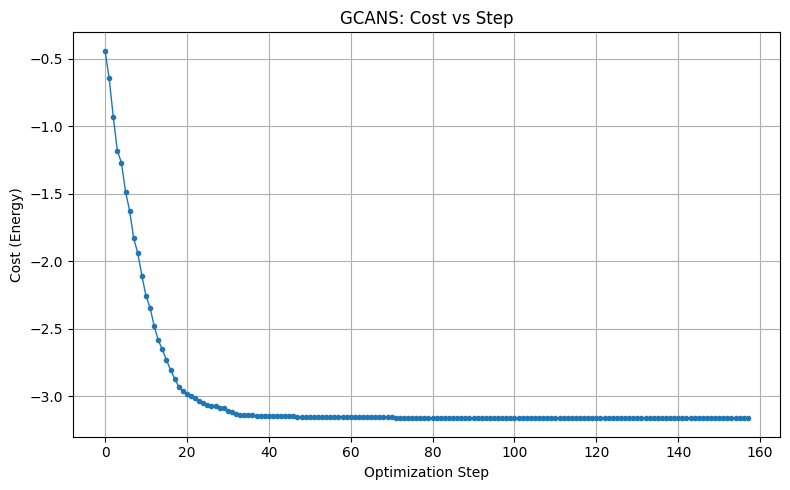

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_gcans)), cost_gcans, marker='o', markersize=3, linewidth=1)
plt.xlabel('Optimization Step')
plt.ylabel('Cost (Energy)')
plt.title('GCANS: Cost vs Step')
plt.grid(True)
plt.tight_layout()
plt.show()